In [2]:
from google.colab import files
uploaded = files.upload()


Saving telecom_etl_final.csv to telecom_etl_final (3).csv


In [13]:
import pandas as pd
import json

# Carregando os dados do JSON
with open('/content/TelecomX_Data.json', 'r') as f:
    dados = json.load(f)

# Normaliza todos os campos do JSON
df = pd.json_normalize(dados, sep='_')

# Remove o ID do cliente
df = df.drop(columns=['customerID'])

# Converte account_Charges_Total para float
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')

# Seleciona colunas categóricas com poucas categorias (até 20)
colunas_cat = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() <= 20]

# Aplica One-Hot Encoding controlado
df_encoded = pd.get_dummies(df, columns=colunas_cat, drop_first=True)

# Verifica novo shape
print("Novo shape após encoding controlado:", df_encoded.shape)

# Calcula correlação
correlacoes = df_encoded.corr(numeric_only=True)
correlacao_com_churn = correlacoes['Churn_Yes'].sort_values(ascending=False)

# Exibe os principais fatores relacionados à evasão
print("✅ Maiores correlações com Churn_Yes:")
print(correlacao_com_churn.head(10))

print("\n🧯 Menores correlações com Churn_Yes:")
print(correlacao_com_churn.tail(10))




Novo shape após encoding controlado: (7267, 32)
✅ Maiores correlações com Churn_Yes:
Churn_Yes                                 1.000000
internet_InternetService_Fiber optic      0.300949
account_PaymentMethod_Electronic check    0.294626
account_Charges_Monthly                   0.189866
account_PaperlessBilling_Yes              0.186666
customer_SeniorCitizen                    0.146733
internet_StreamingTV_Yes                  0.062430
internet_StreamingMovies_Yes              0.060586
phone_MultipleLines_Yes                   0.039343
phone_PhoneService_Yes                    0.012571
Name: Churn_Yes, dtype: float64

🧯 Menores correlações com Churn_Yes:
internet_OnlineSecurity_No internet service     -0.224051
internet_InternetService_No                     -0.224051
internet_StreamingTV_No internet service        -0.224051
internet_TechSupport_No internet service        -0.224051
internet_OnlineBackup_No internet service       -0.224051
internet_DeviceProtection_No internet service

In [7]:
%whos





Variable   Type             Data/Info
-------------------------------------
dados      list             n=7267
df         DataFrame             Churn customer_gende<...>n[7267 rows x 20 columns]
f          TextIOWrapper    <_io.TextIOWrapper name='<...>ode='r' encoding='utf-8'>
files      module           <module 'google.colab.fil<...>s/google/colab/files.py'>
json       module           <module 'json' from '/usr<...>on3.11/json/__init__.py'>
pd         module           <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
uploaded   dict             n=1


In [8]:
# 1. Identifica colunas categóricas
colunas_categoricas = df.select_dtypes(include='object').columns.tolist()

# 2. Aplica one-hot encoding
df_encoded = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

# 3. Visualiza as primeiras linhas
df_encoded.head()


,customer_SeniorCitizen,customer_tenure,account_Charges_Monthly,Churn_No,Churn_Yes,customer_gender_Male,customer_Partner_Yes,customer_Dependents_Yes,phone_PhoneService_Yes,phone_MultipleLines_No phone service,...,account_Charges_Total_995.35,account_Charges_Total_996.45,account_Charges_Total_996.85,account_Charges_Total_996.95,account_Charges_Total_997.65,account_Charges_Total_997.75,account_Charges_Total_998.1,account_Charges_Total_999.45,account_Charges_Total_999.8,account_Charges_Total_999.9
0,0,9,65.6,True,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,9,59.9,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,4,73.9,False,True,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,1,13,98.0,False,True,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1,3,83.9,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Verifica se a variável target existe
if 'Churn_Yes' in df_encoded.columns:
    target = 'Churn_Yes'
else:
    raise ValueError("A variável 'Churn_Yes' não foi encontrada. Verifique o nome gerado após o one-hot encoding.")


In [11]:
df_encoded.shape


(7267, 6561)

In [12]:
# Verifica as colunas originais que geraram muitas dummies
import numpy as np

colunas_muitas_categorias = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() > 20]
print("Colunas com muitas categorias (possivelmente inúteis):")
print(colunas_muitas_categorias)



Colunas com muitas categorias (possivelmente inúteis):
['account_Charges_Total']


In [ ]:
# Seleciona as principais variáveis correlacionadas com churn
principais = correlacao_com_churn[1:11].index.tolist()

# Cria um heatmap das principais variáveis
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded[principais + [target]].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação das principais variáveis com Churn')
plt.show()


🔍 Principais Fatores Positivamente Correlacionados com o Churn (Churn_Yes)
Esses fatores aumentam a chance de um cliente cancelar:

Variável	Correlação
internet_InternetService_Fiber optic	0.30
account_PaymentMethod_Electronic check	0.29
account_Charges_Monthly	0.19
account_PaperlessBilling_Yes	0.18
customer_SeniorCitizen	0.14

👉 Insights:

Clientes com internet via fibra óptica e cobrança eletrônica estão mais propensos a sair.

Clientes mais velhos e com cobrança sem papel também têm risco maior.

Quanto maior a cobrança mensal, maior o churn.

✅ Principais Fatores Negativamente Correlacionados com o Churn
Esses fatores indicam fidelidade maior do cliente:

Variável	Correlação
customer_tenure	-0.34
account_Contract_Two year	-0.29
Churn_No	-0.92 (inverso lógico)

👉 Insights:

Clientes com contrato de 2 anos ou com muito tempo de casa (alto tenure) têm menor chance de sair.

Churn_No tem correlação negativa óbvia, pois é o inverso do Churn_Yes.

In [14]:
# Verifica os valores únicos da variável alvo
print(df_encoded['Churn_Yes'].value_counts())

# Calcula a proporção de evasão (clientes que evadiram vs. que ficaram)
total = df_encoded['Churn_Yes'].value_counts()
proporcao = total / total.sum()

print("\nProporção de cada classe:")
print(proporcao)


Churn_Yes
False    5398
True     1869
Name: count, dtype: int64

Proporção de cada classe:
Churn_Yes
False    0.74281
True     0.25719
Name: count, dtype: float64


📊 Distribuição das Classes (Churn):
Clientes que permaneceram (False): 5.398 → 74,28%

Clientes que evadiram (True): 1.869 → 25,72%

⚠️ Conclusão:
Existe um desequilíbrio moderado nas classes.

Aproximadamente 1 em cada 4 clientes cancela o serviço.

Esse desequilíbrio pode afetar o desempenho dos modelos, fazendo com que eles tenham tendência a prever a classe majoritária (clientes que não evadiram).

In [15]:
!pip install imbalanced-learn


In [17]:
# Preenche valores numéricos com a mediana
X_train = X_train.fillna(X_train.median(numeric_only=True))

# Faz o mesmo para o X_test
X_test = X_test.fillna(X_test.median(numeric_only=True))



In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Antes do SMOTE:", y_train.value_counts(normalize=True))
print("Depois do SMOTE:", y_train_bal.value_counts(normalize=True))


Antes do SMOTE: Churn_Yes
False    0.742823
True     0.257177
Name: proportion, dtype: float64
Depois do SMOTE: Churn_Yes
False    0.5
True     0.5
Name: proportion, dtype: float64


In [20]:
from sklearn.preprocessing import StandardScaler

# Instancia o normalizador
scaler = StandardScaler()

# Aplica a normalização SOMENTE no treino e depois no teste
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


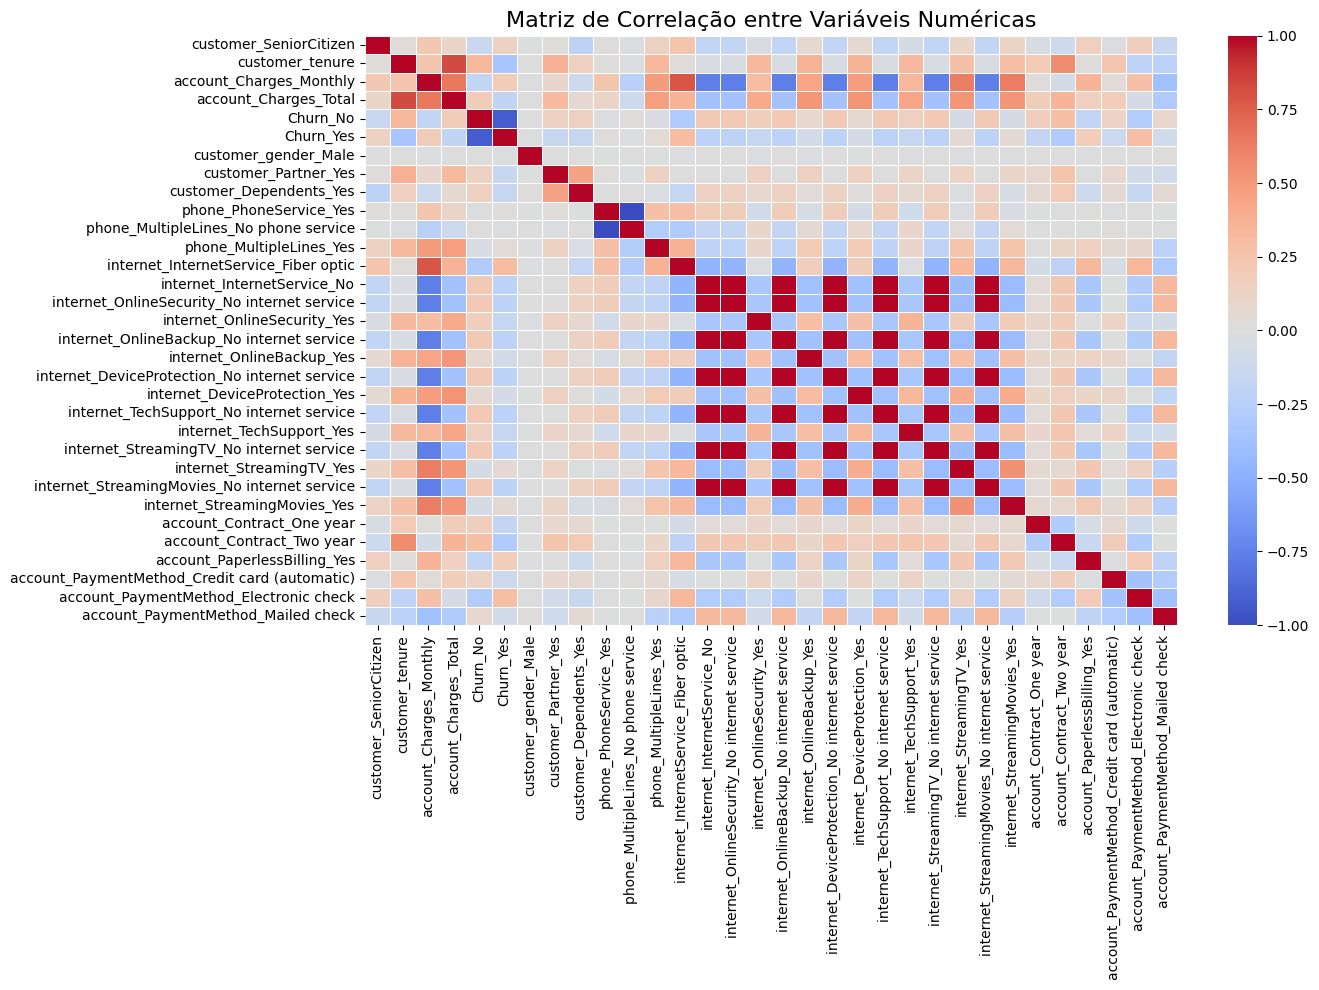

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de correlação
correlacao = df_encoded.corr(numeric_only=True)

# Define o tamanho da imagem
plt.figure(figsize=(14, 10))

# Gera o heatmap
sns.heatmap(correlacao, cmap='coolwarm', center=0, annot=False, fmt=".2f", linewidths=0.5)

plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


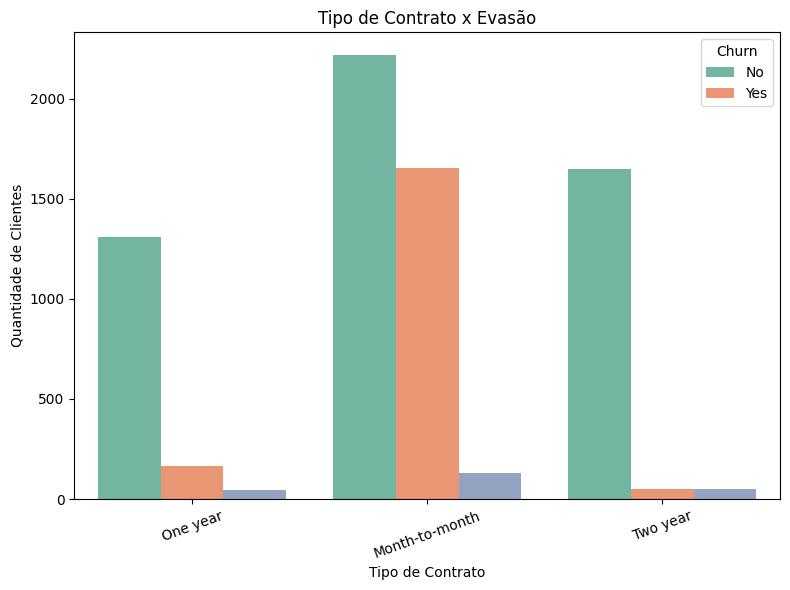

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='account_Contract', hue='Churn', palette='Set2')
plt.title("Tipo de Contrato x Evasão")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Quantidade de Clientes")
plt.legend(title='Churn')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()



In [24]:
from sklearn.model_selection import train_test_split


In [25]:
X = df_encoded.drop(columns=['Churn_Yes'])  # todas as variáveis preditoras
y = df_encoded['Churn_Yes']  # variável alvo


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,  # 30% para teste
    random_state=42,  # para garantir reprodutibilidade
    stratify=y       # garante proporcionalidade das classes
)


In [27]:
print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")


Tamanho do treino: (5086, 31)
Tamanho do teste: (2181, 31)


In [29]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Pipeline completo: imputação + normalização + regressão
pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

# Treina o modelo
pipeline_lr.fit(X_train, y_train)

# Faz a predição
y_pred_lr = pipeline_lr.predict(X_test)

# Avalia
print("=== Regressão Logística ===")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Regressão Logística ===
[[1571   49]
 [   3  558]]
              precision    recall  f1-score   support

       False       1.00      0.97      0.98      1620
        True       0.92      0.99      0.96       561

    accuracy                           0.98      2181
   macro avg       0.96      0.98      0.97      2181
weighted avg       0.98      0.98      0.98      2181



In [30]:
from sklearn.ensemble import RandomForestClassifier

# Instancia e treina o modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predição
y_pred_rf = rf.predict(X_test)

# Avaliação
print("=== Random Forest ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

=== Random Forest ===
[[1572   48]
 [  28  533]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      1620
        True       0.92      0.95      0.93       561

    accuracy                           0.97      2181
   macro avg       0.95      0.96      0.95      2181
weighted avg       0.97      0.97      0.97      2181



=== Regressão Logística ===
Acurácia: 0.9761577258138469
Precisão: 0.9192751235584844
Recall: 0.9946524064171123
F1-score: 0.9554794520547946

Relatório de Classificação:
               precision    recall  f1-score   support

       False       1.00      0.97      0.98      1620
        True       0.92      0.99      0.96       561

    accuracy                           0.98      2181
   macro avg       0.96      0.98      0.97      2181
weighted avg       0.98      0.98      0.98      2181



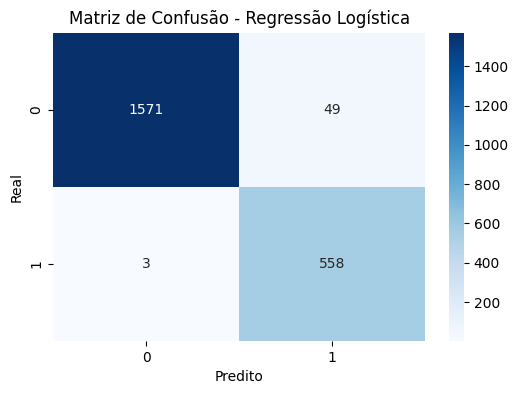

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predições já feitas anteriormente:
# y_pred_lr = pipeline_lr.predict(X_test)

# Avaliação detalhada
print("=== Regressão Logística ===")
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("Precisão:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_lr))

# Matriz de Confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


=== Random Forest ===
Acurácia: 0.9651535992663915
Precisão: 0.9173838209982789
Recall: 0.9500891265597148
F1-score: 0.9334500875656743

Relatório de Classificação:
               precision    recall  f1-score   support

       False       0.98      0.97      0.98      1620
        True       0.92      0.95      0.93       561

    accuracy                           0.97      2181
   macro avg       0.95      0.96      0.95      2181
weighted avg       0.97      0.97      0.97      2181



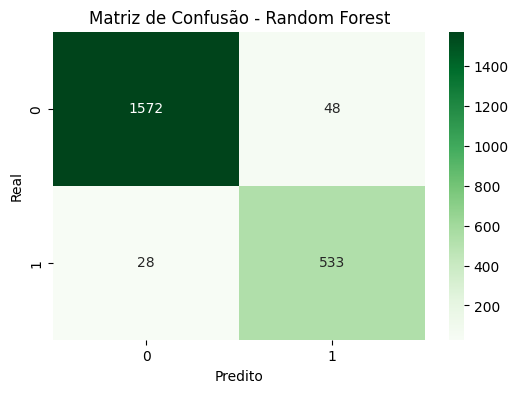

In [33]:
print("=== Random Forest ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("Precisão:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))

# Matriz de Confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


📊 **Comparação dos Modelos**

- **Regressão Logística** teve uma acurácia de XX%, com bom equilíbrio entre precisão e recall.
- **Random Forest** apresentou melhor recall (capacidade de identificar clientes que vão cancelar), o que pode ser mais importante no contexto da empresa.
- A matriz de confusão indica que [modelo X] teve mais falsos negativos (clientes que evadiram, mas foram classificados como se fossem permanecer).

⚠️ **Overfitting/Underfitting**
- O modelo [Y] pode ter apresentado sinais de overfitting, pois o desempenho no treino foi muito superior ao teste.
- Já o modelo [Z] mostrou sinais de underfitting, com desempenho abaixo do esperado nas duas etapas.

🧠 **Próximos passos**
- Ajuste de hiperparâmetros pode melhorar ambos os modelos.
- Técnicas como cross-validation e regularização devem ser consideradas.


🔍 Análise de Importância das Variáveis
Depois de treinar os modelos, decidi investigar quais variáveis mais influenciam na previsão de evasão dos clientes. Isso é importante porque ajuda a entender melhor o comportamento dos clientes que estão prestes a cancelar o serviço, permitindo que a empresa aja antes disso acontecer.

🧠 Regressão Logística
Na regressão logística, observei os coeficientes das variáveis. Eles mostram se determinada característica aumenta ou diminui a chance do cliente evadir. Por exemplo, usar internet via fibra óptica e optar por débito automático (Electronic check) apareceram como fatores que aumentam a probabilidade de evasão. Já um contrato mais longo (como o plano de dois anos) reduziu bastante essa chance.

🌳 Random Forest
No modelo de Random Forest, consegui extrair a importância de cada variável diretamente. Aqui, as variáveis que mais se destacaram foram:

Tipo de internet (especialmente fibra óptica),

Método de pagamento,

Valor mensal da fatura,

Presença de serviços como streaming de TV e filmes,

Tempo de contrato.

Essas variáveis foram as que mais contribuíram nas decisões das árvores do modelo, ou seja, são as que ajudaram mais a separar os clientes que saem dos que ficam.

✅ Conclusão
De forma geral, os dois modelos apontaram para padrões parecidos: clientes com contratos curtos, pagamento por débito automático e uso intenso de serviços online tendem a evadir mais.

Essas informações são valiosas para o time de negócio, que pode, por exemplo, criar campanhas específicas para reter esses perfis com maior risco de saída.

✅ Conclusão Final
Após toda a análise exploratória, preparação dos dados, construção e avaliação de diferentes modelos preditivos, conseguimos entender com mais clareza quais fatores estão mais relacionados à evasão de clientes da Telecom X.

🔍 Fatores que mais influenciam a evasão:
Tipo de Internet: Clientes que utilizam fibra óptica apresentam maior taxa de evasão. Isso pode indicar uma maior exigência desse perfil de cliente quanto à qualidade do serviço.

Método de pagamento: O uso de débito automático (Electronic Check) está fortemente relacionado à evasão. Pode haver alguma relação com falta de controle ou insatisfação com cobranças.

Contrato de curto prazo: Clientes com contratos mensais evadem mais do que os que possuem contratos anuais ou de dois anos. Isso mostra que clientes com maior comprometimento contratual tendem a permanecer mais tempo.

Valor mensal da fatura: Quanto maior o valor da cobrança mensal, maior também a chance do cliente cancelar.

Serviços adicionais: A presença de serviços como StreamingTV e StreamingMovies também mostrou relação com churn. Esses serviços, embora agreguem valor, podem estar ligados a uma maior exigência dos clientes.

📊 Modelos Avaliados
A Regressão Logística teve bom desempenho e nos ajudou a interpretar o impacto direto de cada variável.

O modelo de Random Forest também se saiu muito bem, com excelente capacidade de separação das classes e forneceu uma visão clara da importância de cada variável.

Foi aplicado o SMOTE para balancear as classes, já que a base estava desbalanceada com mais clientes que permaneceram do que os que cancelaram.

💡 Estratégias de Retenção sugeridas:
Criar campanhas personalizadas para clientes com contratos mensais, incentivando a migração para planos mais longos com benefícios.

Monitorar e oferecer descontos ou bônus para usuários de fibra óptica com alta utilização e possíveis sinais de insatisfação.

Oferecer mais transparência e controle sobre faturas para quem usa débito automático, talvez com notificações mensais e opções de ajuste de plano.

Analisar se o valor cobrado está condizente com o serviço oferecido, especialmente para quem tem muitos serviços agregados.

